In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import pandas as pd
import math
import scipy as sp
from scipy.ndimage import gaussian_filter, binary_dilation
from skimage.measure import regionprops, label
import skimage
import skimage.io
from skimage.morphology import disk
from skimage.filters import rank

plt.style.use('styleNB.mplstyle')

import cv2
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# interpixel conversion
ip = 210.0/995.0 #995 pixels / 210 um interpixel distance

######################################
######################################
# Functions for segmentation
######################################
######################################

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening

def generate_gradient_mask(image, threshold=50):
    """
    Generates a binary mask based on the gradient magnitude.

    Parameters:
        image (np.ndarray): The input 2D image.
        threshold (int): The threshold value for gradient magnitude.

    Returns:
        np.ndarray: The binary mask.
    """
    # Convert image to grayscale
    image = image.astype(np.float32)

    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold the gradient magnitude to generate the mask
    mask = (gradient_magnitude > threshold).astype(np.uint8)

    return mask


def smooth_mask_edges_morphological(mask, sigma=1.0, threshold=0.5, closing_iterations=1, opening_iterations=1):
    """
    Smooth the edges of a binary mask using Gaussian blurring followed by morphological closing and opening.
    
    Parameters:
    mask (np.ndarray): The input binary mask image.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    threshold (float): The threshold to convert the smoothed mask back to binary.
    closing_iterations (int): The number of iterations for the closing operation.
    opening_iterations (int): The number of iterations for the opening operation.
    
    Returns:
    np.ndarray: The smoothed binary mask image.
    """
    # Ensure the mask is binary (0 or 1)
    binary_mask = mask.astype(np.float32)
    
    # Apply Gaussian filter for smoothing
    smoothed_mask = gaussian_filter(binary_mask, sigma=sigma)
    
    # Normalize the smoothed mask to the range [0, 1]
    smoothed_mask = (smoothed_mask - smoothed_mask.min()) / (smoothed_mask.max() - smoothed_mask.min())
    
    # Apply threshold to convert back to binary mask
    smoothed_binary_mask = (smoothed_mask > threshold).astype(np.int32)
    
    # Apply morphological closing to smooth the edges
    closed_mask = binary_closing(smoothed_binary_mask, iterations=closing_iterations)
    
    # Apply morphological opening to further smooth the edges
    opened_mask = binary_opening(closed_mask, iterations=opening_iterations)
    
    return opened_mask.astype(np.int32)

######################################
######################################
# Functions for fitting
######################################
######################################

def model_func(t, A, K, C):
    return A * np.exp(K * t) + C    

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

In [3]:
def analysis_identifyCells(f, threshold):
    df_cells = pd.DataFrame()
    im_mask_ = np.empty((151, 1024, 1024))

    ######################
    # Segmentation
    ######################

    # load image 
    img = AICSImage(f)  
    im = img.get_image_data("TCZYX") 
    im_ph = im[:,0,0,:,:] # select phase image
    im_gfp = im[:,1,0,:,:] 

    # perform segmentation
    for i in np.arange(im_ph.shape[0]): #[:1]:
        # gradient of phase image, with threshold cutoff to identify cell boundaries 
        im_temp = generate_gradient_mask(im_ph[i,:,:], threshold=threshold)#600)

        # dilate to connect any discontinuities and fill holes
        bw = sp.ndimage.binary_dilation(im_temp, structure = np.ones((1,1)), iterations=1)
        bw = sp.ndimage.binary_fill_holes(bw)

        # erode a bit to shrink masks
        bw_mask = sp.ndimage.binary_erosion(bw, structure = np.ones((3,3)), iterations=2)

        # smooth_mask_edges
        im_mask_[i,:,:] = smooth_mask_edges_morphological(bw_mask, 
                                                         sigma=3.0, 
                                                         threshold=0.5, 
                                                         closing_iterations=2, 
                                                         opening_iterations=2)


    ######################
    # Identify cells to quantify
    ######################

    im_labeled, n_labels = skimage.measure.label(im_mask_[0,:,:], background=0, return_num=True)
    im_props = skimage.measure.regionprops(im_labeled)

    for L, prop in enumerate(im_props):

        # identify only the cells that have decent fluorescence
        im_labeled_temp = im_labeled.copy()
        im_labeled_temp[im_labeled_temp!=L+1] = 0

        # Only select objects that are big enough to be a cell and are fluorescent
        if np.all([prop.area >= 1000, np.mean(np.multiply(im_labeled_temp, im_gfp[0,:,:])) >=0.5]):

            datalist = {'cell' : L+1,
                        'centroid' : prop.centroid, 
                        'current' : f.split('mA')[0][-3:]+'mA',
                        'electric field' : dict_files_E[f],
                        'trial' : f.split('mA')[1][1],
                       'file' : f}

            df_cells = pd.concat([df_cells, pd.DataFrame([datalist])], ignore_index=True)
            
    return df_cells, im_mask_, im_gfp



def analysis_fcn(im_gfp, im_mask_, df_cells, left_bound, right_bound, 
                 upper_bound, lower_bound, cell, cellular_auto, frames):          

    for g, d in df_cells.groupby(['current', 'trial']):
        print(g)
        im_mask = im_mask_


        for cell_val in d.cell.unique():
            if cell_val != cell:
                continue
            print(cell_val)
            

            for count, i in enumerate(frames):
                #######
                # 1. Identify cell in mask 
                #######

                im_labeled_0, _ = skimage.measure.label(im_mask[0,:,:], background=0, return_num=True)
                centroid_y = np.floor(d[d.cell == cell_val].centroid.values[0]).astype('int')[0]
                centroid_x = np.floor(d[d.cell == cell_val].centroid.values[0]).astype('int')[1]
                ind = im_labeled_0[centroid_y, centroid_x]
                im_labeled_0[im_labeled_0 != ind] = 0

                im_labeled, _ = skimage.measure.label(im_mask[i,:,:], background=0, return_num=True)

                if len(np.unique(np.multiply(im_labeled_0, im_labeled))) < 2:
                    continue

                ind_update = np.unique(np.multiply(im_labeled_0, im_labeled))[1]/ind

                im_labeled[im_labeled != ind_update] = 0
                im_labeled[im_labeled>0] = 1

                im_m = im_labeled

                #######
                # 2. Crop region of interest with some padding around cell (for both intensity image and mask)
                #######
                rows, cols = np.where(im_labeled == 1)
                pad = 0
                min_row, max_row = np.max([0,np.min(rows)-pad]), np.min([1024, np.max(rows)+pad])
                min_col, max_col = np.max([0,np.min(cols)-pad]), np.min([1024, np.max(cols)+pad])

                im_temp = im_gfp[i,min_row:max_row,min_col:max_col]

                vals = np.mean(im_temp[int(im_temp.shape[0]/2)+upper_bound:int(im_temp.shape[0]/2)+lower_bound,:], axis = 0)

                #######
                # 3. Quantify  intensity
                #######

                # Convert to real micron units 
                # Since I split the edge into 300 posiitons, 
                # need to convert to pixels and then to micron.
                x = np.arange(len(vals))/(995/210)

                # correct for autofluorescence
                vals_zeroed = vals - cellular_auto
                # renomormalize for plot (doesn't change fit results)
                vals_renorm = vals_zeroed/ np.max(vals_zeroed)
                
                #######
                # 4. Take a look at values
                #######

                # Create a figure
                fig = plt.figure(figsize=(8, 4), tight_layout=True)

                # Define a GridSpec with the desired width ratios
                gs = GridSpec(1, 3, width_ratios=[2, 1, 1], figure=fig)

                # Create subplots
                ax1 = fig.add_subplot(gs[0])
                ax2 = fig.add_subplot(gs[1])
                ax3 = fig.add_subplot(gs[2])


                ax1.plot(x, vals_renorm, 'ro',alpha = 0.4)
                ax1.set_ylabel('fluorescence\nintensity (a.u.)')
                ax1.set_xlabel(r'position along cell edge ($\mu$m)')

                ax2.imshow(im_temp)

                ax3.imshow(im_temp[int(im_temp.shape[0]/2)+upper_bound:int(im_temp.shape[0]/2)+lower_bound,:])
                ax3.set_title(str(cell_val))

                # region of interest (avoid edges)
                x_ = x[left_bound:right_bound]
                vals_renorm_ =  vals_renorm[left_bound:right_bound]

                # for fitting
                x__= x_
                y__ = vals_renorm_


                ax1.plot(x, vals_renorm , 'ro',alpha = 0.4)
                ax1.plot(x_, vals_renorm_ , 'bo',alpha = 0.4)

                A = 1
                K1 = -0.1
                A, K1 = fit_exp_linear(x__, y__)

                fit_y = model_func(x__, A, K1, 0)

                ax1.plot(x__, fit_y, linewidth = 4.0, color = 'g')
                
                ax1.set_yscale('log')
                print('v/D ~ '+str(np.round(np.abs(K1),3))+r' $\mu$m$^{-1}$')
                
                ax1.set_ylim(0.1,1)
                ax1.set_yscale('log')
    
        return x, vals_renorm, x__, y__


In [10]:
files = ['../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_0.6mA_4/20240712_LatA_GalvGFP_0.6mA_4_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_0.6mA_3/20240712_LatA_GalvGFP_0.6mA_3_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_0.6mA_2/20240712_LatA_GalvGFP_0.6mA_2_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_1.2mA_1/20240712_LatA_GalvGFP_1.2mA_1_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240711_LatA/20240711_LatA_GalvGFP_1.2mA_2/20240711_LatA_GalvGFP_1.2mA_2_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240711_LatA/20240711_LatA_GalvGFP_1.2mA_1/20240711_LatA_GalvGFP_1.2mA_1_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240711_LatA/20240711_LatA_GalvGFP_2.2mA_2/20240711_LatA_GalvGFP_2.2mA_2_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_2.2mA_3/20240712_LatA_GalvGFP_2.2mA_3_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240712_LatA/20240712_LatA_GalvGFP_2.2mA_2/20240712_LatA_GalvGFP_2.2mA_2_MMStack_Pos0.ome.tif',
 '../../data/microscopy/Amy/20240711_LatA/20240711_LatA_GalvGFP_2.2mA_1/20240711_LatA_GalvGFP_2.2mA_1_MMStack_Pos0.ome.tif']

files_E = [1.5, 1.5, 1.5, 3, 3, 3, 5, 5, 5, 5]

dict_files_E = dict(zip(files, files_E))

cellular_auto = 160

('0.6mA', '3')
9
v/D ~ 0.047 $\mu$m$^{-1}$
('1.2mA', '2')
11
v/D ~ 0.077 $\mu$m$^{-1}$
('2.2mA', '2')
3
v/D ~ 0.171 $\mu$m$^{-1}$


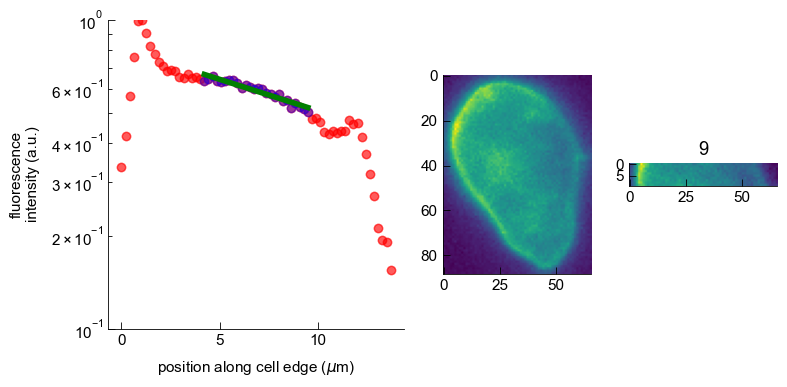

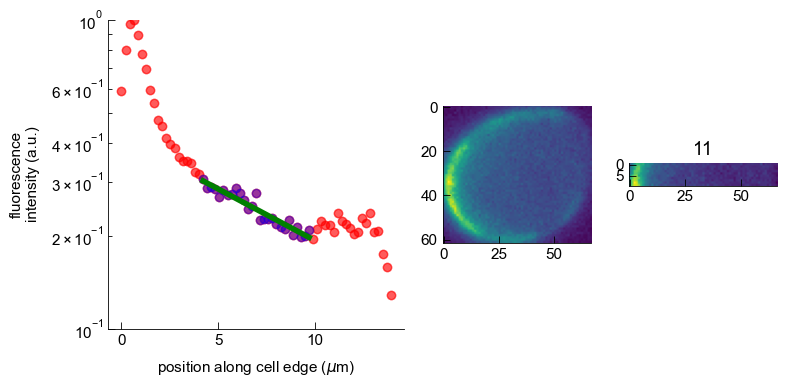

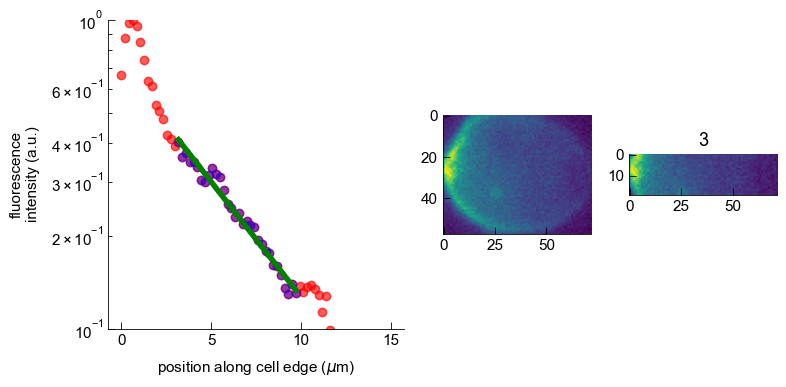

In [11]:
###############################
###############################
f = files[1]
threshold = 400

df_cells, im_mask_, im_gfp = analysis_identifyCells(f, threshold)
df_cells

cell = 9

# region e.g. [20:-20]
leftbound = 20
rightbound = -20

# region e.g. [centroid_y -10: centroid_y + 10]
upperbound = -20
lowerbound = -10

frames = np.arange(89,90)

x_1_5,y_1_5,x_fit_1_5, y_fit_1_5 = analysis_fcn(im_gfp, im_mask_, df_cells, leftbound, 
             rightbound, upperbound, lowerbound,
             cell, cellular_auto, frames)

A = 1 # initial guess
K1 = -0.1 #initial guess
A_1_5, K1_1_5 = fit_exp_linear(x_fit_1_5, y_fit_1_5)
# fit prediction
fit_y_1_5 = model_func(x_fit_1_5, A_1_5, K1_1_5, 0)


###############################
###############################
f = files[4]
threshold = 600

df_cells, im_mask_, im_gfp = analysis_identifyCells(f, threshold)


# [ 1,  3,  4,  5,  8, 11, 12, 13, 14, 15, 16, 17, 18]
cell = 11

# region e.g. [20:-20]
left_bound = 20
right_bound = -20

# region e.g. [centroid -10: centroid + 10]
upper_bound = -5
lower_bound = 5

frames = np.arange(89,90)

x_3,y_3,x_fit_3, y_fit_3 = analysis_fcn(im_gfp, im_mask_, df_cells, left_bound, 
             right_bound, upper_bound, lower_bound,
             cell, cellular_auto, frames)

A = 1 # initial guess
K1 = -0.1 #initial guess
A_3, K1_3 = fit_exp_linear(x_fit_3, y_fit_3)
# fit prediction
fit_y_3 = model_func(x_fit_3, A_3, K1_3, 0)

###############################
###############################
f = files[6]
threshold = 600

df_cells, im_mask_, im_gfp = analysis_identifyCells(f, threshold)
df_cells

cell = 3

# region e.g. [20:-20]
left_bound = 15
right_bound = -25

# region e.g. [centroid -10: centroid + 10]
upper_bound = -10
lower_bound = 10

frames = np.arange(89,90)

x_5,y_5,x_fit_5, y_fit_5 = analysis_fcn(im_gfp, im_mask_, df_cells, left_bound, 
             right_bound, upper_bound, lower_bound,
             cell, cellular_auto, frames)


A = 1 # initial guess
K1 = -0.1 #initial guess
A_5, K1_5 = fit_exp_linear(x_fit_5, y_fit_5)
# fit prediction
fit_y_5 = model_func(x_fit_5, A_5, K1_5, 0)


In [15]:
# summarized v/D values from latA treated cells.
vD_1_5_lat = np.array([0.04, 0.059, 0.025, 0.089, 0.016, 0.047, 0.037, 0.027, 0.021, 0.018, 0.017, 0.044, 0.056])

vD_3_lat = np.array([0.092, 0.062, 0.036, 0.128, 0.105, 0.047, 0.095, 0.048, 0.039, 0.082, 
        0.069, 0.056, 0.024, 0.044, 0.077, 0.048, 0.067, 
        0.041, 0.052, 0.185, 0.046, 0.046, 0.089])

vD_5_lat = np.array([0.132, 0.181, 0.15, 0.082, 0.109, 0.077, 0.321, 0.238, 0.078, 0.111, 
        0.126, 0.09, 0.062, 0.127, 0.111, 0.076, 
        0.159, 0.055, 0.052, 0.071, 0.111, 0.21, 0.147, 
        0.106, 0.132, 0.212])

# v/D values from non-treated (non-motile) cells 
vD_3 = np.array([0.101,0.106, 0.063, 0.098])

# convert to estimated number of charges
# 1.5 V/cm -> 0.05 um^-1 == 8.9
# 3 V/cm -> 0.08 um^-1 == 7.13
# 5 V/cm -> 0.18 um^-1 == 9.62

n_1_5_lat = (vD_1_5_lat/(0.05/8.9))/0.37
n_3_lat = (vD_3_lat/(0.08/7.13))/0.37
n_5_lat = (vD_5_lat/(0.18/9.62))/0.37
n_3 = (vD_3/(0.08/7.13))/0.37

In [16]:
# note number of cells quantified

print('1.5-lat', len(vD_1_5_lat))
print('3-lat' , len(vD_3_lat))
print('5-lat', len(vD_5_lat))

1.5-lat 13
3-lat 23
5-lat 26


In [17]:
n_vals_combined = np.append(n_1_5_lat, n_3_lat)
n_vals_combined = np.append(n_vals_combined, n_5_lat)
n_vals_combined = np.append(n_vals_combined, n_3)

print('mean value across all data', np.mean(n_vals_combined))

mean value across all data 17.99678428428428


Text(0, 0.5, 'estimated ectodomain charge ($\\it{e}$)')

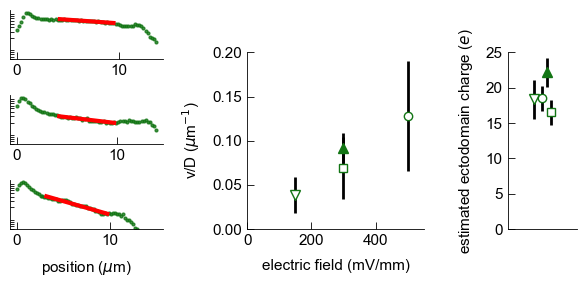

In [29]:
# Create a figure
fig = plt.figure(figsize=(6, 3),  tight_layout=True)

# Define a GridSpec with the desired width ratios
gs = GridSpec(6, 5, width_ratios = [0.5,1,1,1,1.5], figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[2:4, :2])
ax3 = fig.add_subplot(gs[4:, :2])

ax1.plot(x_1_5, y_1_5, 'o', color = '#127514', markersize = 2, alpha = 0.8)
ax1.plot(x_fit_1_5, fit_y_1_5, color = 'r', linewidth=3)

ax2.plot(x_3, y_3, 'o', color = '#127514', markersize = 2, alpha = 0.8)
ax2.plot(x_fit_3, fit_y_3, color = 'r', linewidth=3)

ax3.plot(x_5, y_5, 'o', color = '#127514', markersize = 2, alpha = 0.8)
ax3.plot(x_fit_5, fit_y_5, color = 'r', linewidth=3)

for ax_ in [ax1,ax2,ax3]:
    ax_.set_ylim(0.05,1.2)
    ax_.set_yscale('log')
    ax_.set_yticks([])

ax3.set_xlabel(r'position ($\mu$m)')

##################
##################

ax4 = fig.add_subplot(gs[1:,2:4])

ax4.errorbar(x = 150, y = np.mean(vD_1_5_lat),
             yerr = np.std(vD_1_5_lat),
            marker = 'v', markersize = 7, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax4.errorbar(x = 300, y = np.mean(vD_3_lat),
             yerr = np.std(vD_3_lat),
            marker = 's', markersize = 6, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax4.errorbar(x = 300, y = np.mean(vD_3),
             yerr = np.std(vD_3),
            marker = '^', markersize = 7, linewidth = 2, color = 'k',
            markerfacecolor='#127514', markeredgecolor='#127514')


ax4.errorbar(x = 500, y = np.mean(vD_5_lat),
             yerr = np.std(vD_5_lat),
            marker = 'o', markersize = 6, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax4.set_ylim(0,0.2)
ax4.set_xlim(0,550)
ax4.set_xticks([0,200,400])
ax4.set_xlabel('electric field (mV/mm)')
ax4.set_ylabel(r'v/D ($\mu$m$^{-1}$)')

##################
##################

ax5 = fig.add_subplot(gs[1:,4:])

ax5.errorbar(x = 0.9, y = np.mean(n_1_5_lat),
             yerr = np.std(n_1_5_lat)/(np.sqrt(len(n_1_5_lat))),
            marker = 'v', markersize = 7, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax5.errorbar(x = 1.1, y = np.mean(n_3_lat),
             yerr = np.std(n_3_lat)/(np.sqrt(len(n_3_lat))),
            marker = 's', markersize = 6, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax5.errorbar(x = 1.05, y = np.mean(n_3),
             yerr = np.std(n_3)/(np.sqrt(len(n_3))),
            marker = '^', markersize = 7, linewidth = 2, color = 'k',
            markerfacecolor='#127514', markeredgecolor = '#127514')

ax5.errorbar(x = 1, y = np.mean(n_5_lat),
             yerr = np.std(n_5_lat)/(np.sqrt(len(n_5_lat))),
            marker = 'o', markersize = 6, linewidth = 2, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514')

ax5.set_ylim(0,25)
ax5.set_xlim(0.6,1.4)
ax5.set_xticks([])
ax5.set_ylim(0,25)
ax5.set_ylabel(r'estimated ectodomain charge ($\it{e}$)')

# fig.savefig('../../figures/20240804_Fig5_wt.pdf')

## negaitve super-charged GFP

In [20]:
vD_5_neg30 = np.array([0.303, 0.185, 0.25, 0.384, 0.189, 0.379, 0.26, 0.366, 0.224, 0.206, 0.265, 0.19, 0.347, 0.133,
            0.245, 0.197, 0.259, 0.23, 0.142, 0.184, 0.398, 0.414, 0.415, 0.355, 0.152, 0.144, 0.245, 0.137])
n_5_neg30 = (vD_5_neg30/(0.18/9.62))/0.37

In [22]:
print('mean: ', np.mean(n_5_neg30), ', SEM: ', sp.stats.sem(n_5_neg30))

mean:  37.13253968253969 , SEM:  2.503295034674547


Text(0.5, 0, 'placeholder')

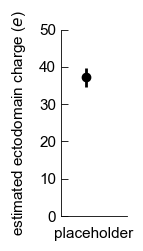

In [28]:
fig = plt.figure(figsize=(1.5, 2.5), tight_layout=True)

plt.errorbar(x = 0.9, y = np.mean(n_5_neg30),
             yerr = np.std(n_5_neg30)/(np.sqrt(len(n_5_neg30))),
            marker = 'o', markersize = 6, linewidth = 2, color = 'k',
            markeredgecolor='k')

plt.ylim(0,50)
plt.xlim(0.6,1.4)
plt.xticks([])
plt.ylim(0,50)
plt.ylabel(r'estimated ectodomain charge ($\it{e}$)')
plt.xlabel('placeholder')

# fig.savefig('../../figures/20240804_Fig5_-30Galv.pdf')